In [1]:
import torch
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn import datasets
from utils import displayMathHelper
from torch.utils.data import Dataset, DataLoader
from IPython.display import Image, display, Math

# 1: Basics

## 1.1: Tensors

In [2]:
# Creating tensors, operating it and particularities

## Empty tensor
x = torch.empty(1) # 1-D empty tensor
x = torch.empty(2, 1) # 2-D empty tensor
# x = torch.empty(n-dimensional tensor) # n-D empty tensor

## Zeros tensor
x = torch.zeros(1) # 1-D zeros tensor

## Ones tensor
x = torch.ones(1) # 1-D ones tensor

## Defining type
x = torch.ones(2,2, dtype=torch.float16)
# print(x.dtype)

## Retrieving tensor size
# print(x.size())

## Creating tensor "from scratch"
x = torch.tensor([[2.5, 5], [1.7, 8]])

## Operations
x = torch.rand(2, 2)
y = torch.rand(2, 2)

### Arithmetic
z = x+y # Element-wise addition
z = torch.add(x,y) # Same result
y.add_(x) # Inplace element-wise addition; functions if "_" before its name make inplace ops

z = x-y # Element-wise subtraction
z = torch.sub(x, y) # Analogous as above
y.sub_(x) # Analogous as above

z = x*y # Element-wise multiplication
z = torch.mul(x, y) # Analogous as above
y.mul_(x) # Analogous as above

z = x / y # Element-wise division
z = torch.div(x, y) # Analogous as above
y.div_(x) # Analogous as above

### Slicing
z = x[:, 1]
z = x[1, 1]

### Reshaping
z = x.view(4)
z = x.view(-1, 2)

### Casting to numpy arrays
z = x.numpy()

### Casting from numpy arrays to pytorch tensors
z = np.array([[1, 3.4], [5, 8.9]])
w = torch.from_numpy(z)

### Working on GPU
# if torch.cuda_is_available():
#     gpu = torch.device("cuda")
#     x = torch.ones(1, 2, device=gpu) # Tensor allocated on GPU
#     y = torch.ones(5) # Tensor allocated on CPU
#     y = y.to(gpu) # Sending tensor instantiated on CPU to GPU

### Observation
#################################################################################
#    When dealing with tensors which you need to compute their gradients        #
#    (e.g in optimization), Pytorch requires defining it explicitly.            #
#################################################################################
# x = torch.ones(4, requires_grad=True) # requires_grad argument is False by default

---

## 1.2: Autograd

Autograd's package: used to ease the calculation of gradients. Its principle is based on Automatic Differentiation (autodiff)
which is a general method for automatically computing the derivative of a value. For more details, I highly recommend checking out
Prof. Roger Grosse lecture's slides¹ about the technique and the following medium post² about Pytorch's implementation of it.

1: https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf <br>
2: https://mustafaghali11.medium.com/how-pytorch-backward-function-works-55669b3b7c62

In [3]:
# First, let's create an input tensor
x = torch.rand(3, requires_grad=True) # Remember that it's necessary to enable requires_grad property

# After creating the input tensor, let's define
# an operation over this tensor.
y = 3*x+2 # Creates the computational graph

**Computational graph created after operating over the tensor:**

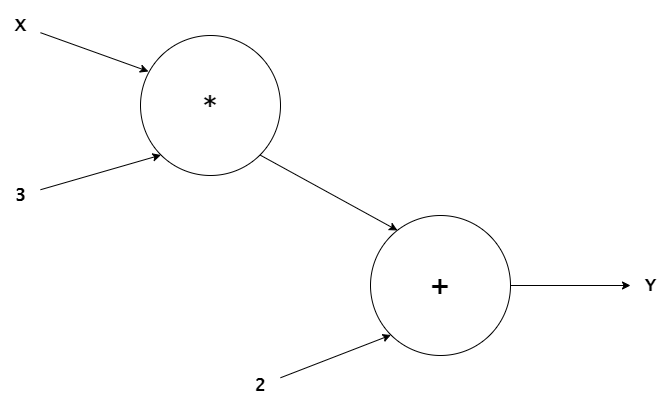

In [4]:
Image(filename="assets/images/compt_graph.png")

In [5]:
print("X:", x)
print("Y:", y)

X: tensor([0.9714, 0.6340, 0.5424], requires_grad=True)
Y: tensor([4.9141, 3.9019, 3.6271], grad_fn=<AddBackward0>)


As seen, tensor X has requires_grad property set as **True** and tensor Y has the last operation over X (addition) as its gradient function. 
In the next example, Z is a tensor computed multiplying Y by itself and your grad. function is the multiplication op.

In [6]:
z = y*y
print(z)

tensor([24.1480, 15.2246, 13.1559], grad_fn=<MulBackward0>)


For the sake of understanding, let's simplify assuming that our output tensor is 1-dimensional.

In [7]:
z = z.mean()
print(z)

tensor(17.5095, grad_fn=<MeanBackward0>)


So, in order to compute Z gradient w.r.t. X, we call the Z backward() function and X grad property.

In [8]:
z.backward()
print(x.grad, '\nThree gradients of Z w.r.t. X, because X is a 3-D tensor')

tensor([9.8281, 7.8037, 7.2542]) 
Three gradients of Z w.r.t. X, because X is a 3-D tensor


On the other hand, if we have a multi-dimensional output tensor, we need to specify a gradient vector as an argument of backward() function
towards the correct execution. In this sense, it's used a 'ones' tensor as the gradient vector in the Jacobian-vector Product - which is
a way for computing partial derivatives, used inside autograd. For more details, please check the references in the head of this section.

In [9]:
y = 3*x+2
z = y*y
size = list(z.size())
init_grad_vec = torch.ones(size)

z.backward(init_grad_vec)
print(x.grad)

tensor([39.3125, 31.2149, 29.0168])


Though Pytorch allocate every gradient of a specific variable, sometimes it's essential to reset our gradients.

In [10]:
for i in range(3):
    y = 3*x + 2
    z = y*y

    z.backward(init_grad_vec)
    print("Step {} gradient vector: {}".format(i+1, x.grad))

_ = x.grad.zero_()

Step 1 gradient vector: tensor([68.7969, 54.6261, 50.7794])
Step 2 gradient vector: tensor([98.2813, 78.0373, 72.5420])
Step 3 gradient vector: tensor([127.7657, 101.4485,  94.3046])


In [11]:
for i in range(3):
    y = 3*x + 2
    z = y*y

    z.backward(init_grad_vec)
    print("Step {} gradient vector: {}".format(i+1, x.grad))
    
    _ = x.grad.zero_()

Step 1 gradient vector: tensor([29.4844, 23.4112, 21.7626])
Step 2 gradient vector: tensor([29.4844, 23.4112, 21.7626])
Step 3 gradient vector: tensor([29.4844, 23.4112, 21.7626])


Sometimes during training we might want to stop tracking variables from the gradient perspective. There are three ways to do so.
(As seen below, none of tensors have the property requires_grad in it)

In [12]:
# First way
x.requires_grad_(False)
# print(x)

# Second way
x.detach()
# print(x)

# Third way
with torch.no_grad():
    y = x + 2
#     print(y)

---

## 1.3: Backpropagation

Backpropagation is an algorithm used to compute gradients of functions w.r.t. parameters that appears previously 
to the function computation, and them is backpropagated to which one of them.

Let's suppose we have a first degree function (w/o linear coefficient, i.e. $y = f(x) = {\theta}x$). Suppose our parameter $\theta = 5$.
In our computational graph Pytorch's framework, such operation should be seen as follows:

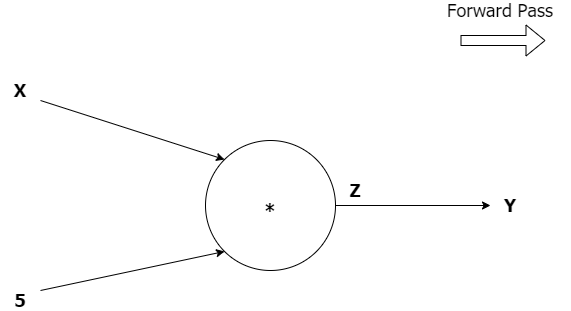

In [13]:
Image(filename="assets/images/bprop_ex_compt_graph_1.png")

Here we have a multiplication operation and the attribution of this result in Y variable (an identity). In the background,
the result of the first operation is seen as an intermediate variable - here called Z -, and them it's attributed to Y, completing
the forward pass stage. Given that, to compute the gradient of Y w.r.t. X it's necessary to operate using the chain rule of calculus,
in order to compute the gradient of Y w.r.t the intermediate variable Z.

---

Briefly, the chain rule assures (not restricted to a 2-step computation. In fact, it's valid, in general, for n-steps):



$\dfrac{dy}{dz}*\dfrac{dz}{dx} = \dfrac{dy}{dx}$

---

The complete computation graph with the forward and backward pass is depicted below:

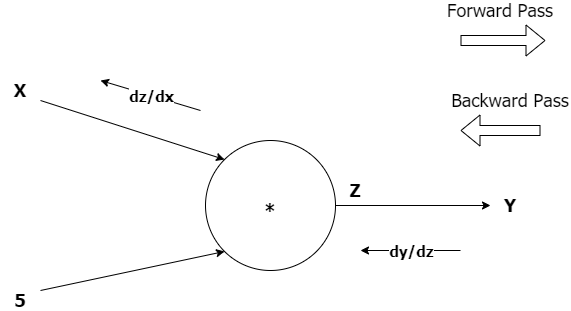

In [14]:
Image(filename="assets/images/bprop_ex_compt_graph_2.png")

The Pytorch implementation of the backpropagation is as simple as follows:

In [15]:
# Instantiate data point
x = torch.tensor([4], dtype=torch.float32, requires_grad=True)

# Computational graph
y = 5*x # dy/dx = 5

# Backward pass
y.backward()
dy = x.grad

print(f'dy/dx = {int(dy.item())} (as expected!)')

dy/dx = 5 (as expected!)


---

## 1.4: Gradient Descent Algorithm

Toward to wrap all of these concepts and enable the algorithm to learn the paremeters' values, the gradient descent algorithm
this task*. This algorithm can be divided in four steps:

* Forward pass
* Loss computation
* Backward pass
* Update parameters

The only which wasn't introduced is the loss computation. In short, since the learning is being supervised, i.e. it's known a priori the correct
output's value, one way to compute 'how much' the approximation function being learned is 'wrong' is computing the error between its
output and the correct value. Here, the loss function used is the well-known Mean Squared Error (MSE)**. 

\* The purpose here isn't to explain all the details of gradient descent algorithm.

\** In the examples below the problem is a regression one.

First, let's code it from scratch, using Numpy:

In [16]:
# Set data points
X = np.array([1, 2, 3, 4, 5], dtype=np.float32)
y = np.array([5, 10, 15, 20, 25], dtype=np.float32)

# Randomly initialize parameter
theta = np.random.randn(1)

# Define hyperparameters
lr = 0.01
num_iters = 100

for i in range(1, num_iters+1):
    # Forward pass
    y_hat = theta*X

    # Loss computation
    J = np.mean((y_hat - y)**2) / 2

    # Backward pass
    dJ = np.mean(X*(y_hat - y)) # This is the derivative of the loss function w.r.t. the parameter theta

    # Update parameter
    theta = theta - lr*dJ

    # Print loss function
    if i % 20 == 0:
        space_str = displayMathHelper(num_iters, i)
        display(Math(r'{space}{i}th \ iter. \ Error (J): {J:.3f} \ | \ Parameter \ (\theta): {theta:.3f}'.format(space=space_str, i=i, J=J, theta=theta[0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now with Pytorch's Autograd (untill gradient computation):

In [17]:
# Set data points
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)
y = torch.tensor([5, 10, 15, 20, 25], dtype=torch.float32)

# Randomly initialize parameter
theta = torch.rand(1, requires_grad=True)

# Define hyperparameters
lr = 0.01
num_iters = 100

for i in range(1, num_iters+1):
    # Forward pass
    y_hat = theta*x

    # Loss computation
    J = torch.mean((y_hat - y)**2 / 2)

    # Backward pass
    J.backward() # dJ/dtheta

    # Update parameter
    ## Remember that we don't want to track this operation in our computational graph. Given that
    ## we should wrap our update operation inside the torch.no_grad(), as explained before.
    with torch.no_grad():
        theta -= lr*theta.grad

    # Zero theta gradients
    theta.grad.zero_()

    # Print loss function and theta updating
    if i % 20 == 0:
        space_str = displayMathHelper(num_iters, i)
        display(Math(r'{space}{i}th \ iter. \ Error (J): {J:.3f} \ | \ Parameter \ (\theta): {theta:.3f}'.format(space=space_str, i=i, J=J, theta=theta[0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---

## 1.5: Training Pipeline

Previously, we implemented our training in two ways: (i) all from scratch; (ii) from scratch mixed with Pytorch's autograd package. 
Now we'll write all the training pipeline with Pytorch. First, let's recap how we trained our linear regression model mixing
from scratch with autograd:

In [18]:
# Set data points
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)
y = torch.tensor([5, 10, 15, 20, 25], dtype=torch.float32)

# Randomly initialize parameter
theta = torch.rand(1, requires_grad=True)

# Define hyperparameters
lr = 0.01
num_iters = 100

for i in range(1, num_iters+1):
    # Forward pass
    y_hat = theta*x

    # Loss computation
    J = torch.mean((y_hat - y)**2 / 2)

    # Backward pass
    J.backward() # dJ/dtheta

    # Update parameter
    ## Remember that we don't want to track this operation in our computational graph. Given that
    ## we should wrap our update operation inside the torch.no_grad(), as explained before.
    with torch.no_grad():
        theta -= lr*theta.grad

    # Zero theta gradients
    theta.grad.zero_()

    # Print loss function and theta updating
    if i % 20 == 0:
        space_str = displayMathHelper(num_iters, i)
        display(Math(r'{space}{i}th \ iter. \ Error \ (J): {J:.3f} \ | \ Parameter \ (\theta): {theta:.3f}'.format(space=space_str, i=i, J=J, theta=theta[0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

As stated above, now we'll implement a linear regression in a fully-Pytorch version. For that, we need to add some steps:

1. The model needs to be fed with a matrix whose lines are related to examples and columns to features. In our 1-D example, we need to reshape our covariates and target variables to be a column vector.
2. The instance of the model object (in our case, a linear one).
3. In order to compute loss and gradients, we need to specify which loss object we want (for a linear regression, good old MSE) and which optimizer. For that example, we use stochastic gradient descent optimizer.

Implementation is as follows:

In [19]:
# Set data points
X = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)
y = torch.tensor([5, 10, 15, 20, 25], dtype=torch.float32)

## Reshaping as column vectors
X = X.view(X.shape[0], 1)
y = y.view(y.shape[0], 1)

# Design model
n_samples, n_features = X.shape
model = nn.Linear(in_features=n_features, out_features=n_features)

# Define hyperparameters
lr = 0.01
num_iters = 2000

# Construct Loss and Optimizer
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr) # Obs.: model.parameters() is a generator object of torch.nn.parameter which has requires_grad set True

final_iter_magnitude = np.floor(np.log10(num_iters)).astype(np.int32)
for i in range(1, num_iters+1):
    # Forward pass
    y_hat = model(X)

    # Loss computation
    J = loss(y_hat, y)

    # Backward pass
    J.backward() # dJ/dtheta

    # Update parameter
    optimizer.step()

    # Zero theta gradients
    optimizer.zero_grad()

    # Print loss function and theta updating
    if i % 400 == 0:
        theta, b = model.parameters()

        space_str = displayMathHelper(num_iters, i)
        display(Math(r'{space}{i}th \ iter. \ Error (J): {J:.3f} \ | \ Parameter \ (\theta): {theta:.3f}'.format(space=space_str, i=i, J=J, theta=theta.item())))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---

## 1.6: Linear Regression

In this section we'll use the acquired knowledge about how to implement a linear regression fully with Pytorch to a toy dataset. Let's load the dataset:

In [20]:
# Loading data
X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1,
                                            noise=15, random_state=1)

## Transform Numpy vectors to Pytorch tensors
X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))

## Reshaping as column vectors
X = X.view(X.shape[0], 1)
y = y.view(y.shape[0], 1)

Then, we follow the steps followed before:

* Design model (a linear one for that problem)
* Construct loss function and optimizer
* Forward pass
* Backward pass
* Update parameters

In order to visualize results, it is plotted data points scatter with the line learned.

In [21]:
# Design model
n_samples, n_features = X.shape
model = nn.Linear(in_features=n_features, out_features=n_features)

# Define hyperparameters
lr = 0.01
num_iters = 1000

# Construct Loss and Optimizer
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for i in range(1, num_iters+1):
    # Forward pass
    y_hat = model(X)

    # Loss computation
    J = loss(y_hat, y)

    # Backward pass
    J.backward() # dJ/dtheta

    # Update parameter
    optimizer.step()

    # Zero theta gradients
    optimizer.zero_grad()

    # Print loss function and theta updating
    if i % 200 == 0:
        theta, b = model.parameters()

        space_str = displayMathHelper(num_iters, i)
        display(Math(r'{space}{i}th \ iter. \ Error (J): {J:.3f} \ | \ Parameter \ (\theta): {theta:.3f}'.format(space=space_str, i=i, J=J, theta=theta.item())))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

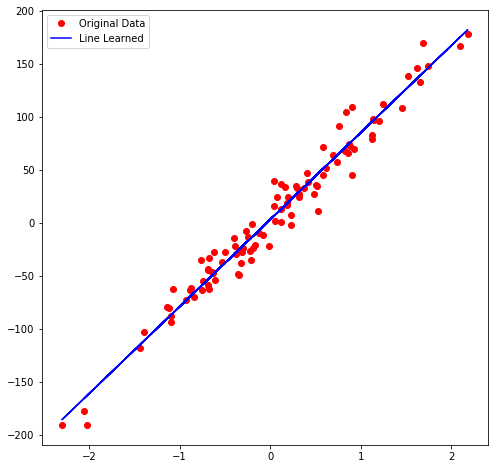

In [22]:
predicted = model(X).detach().numpy() # We don't want that op. on computational graph.

fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.plot(X_numpy, y_numpy, 'ro', label="Original Data")
axs.plot(X_numpy, predicted, 'b', label="Line Learned")
axs.legend(loc="upper left")
plt.show()

---

## 1.7: Logistic Regression

Previously, we learned how to implement a linear model in the context of a linear regression problem fully with Pytorch. In this section we'll learn to implement the Logistic Regression classification algorithm.

First of all, there isn't an implemented interface on Pytorch as in the case of our linear model. Given that, we'll need to build our own Logistic Regression class. In summary, Logistic Regression is a model used in classification tasks that has two-steps:

* First, it's applied a linear transformation of the same kind it's done in linear regression (z = A*x + b).
* Second, a non-linear limited function is applied in order to constraint the output value. In our model, we'll use the logistic function (also known as sigmoid function).

With this in mind, let's create our Logistic Regression class:

In [23]:
class LogRegression(nn.Module): # Inherit torch.nn.Module. This enable us to access methods, attributes and other classes that inherit this parent class.

    def __init__(self, n_features, n_classes):
        super().__init__()
        self.Linear = nn.Linear(in_features=n_features, out_features=n_classes)

    def forward(self, x):
        predicted = torch.sigmoid(self.Linear(x))
        return predicted

After constructing the class, let's generate and load our toy dataset:

In [24]:
# Loading and transforming data. 

## Don't care too much about the data itself. Nevertheless, have in mind that our data is generated 
## with few constraints (e.g., it's a 100 examples size, it has 2 features and 3 classes as possible values 
## to target variable).
X_numpy, y_numpy = datasets.make_classification(n_samples=100, n_features=2, 
                                                n_redundant=0, n_classes=3,
                                                n_clusters_per_class=1, random_state=1)

X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy)
y = y.type(torch.long)

Training pipeline follows the same steps as before:

* Design model
* Construct loss function and optimizer
* Forward pass
* Backward pass
* Update parameters

In [25]:
# Design model
n_samples, n_features = X.shape
n_classes = y.unique().shape[0]
model = LogRegression(n_features, n_classes)

# Define hyperparameters
lr=0.01
num_iters=1000

# Construct Loss and Optimizer
loss = nn.CrossEntropyLoss() # Since we're tackling a classification task, loss function needs to fit adequately.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(1, num_iters+1):
    # Forward pass
    y_hat = model(X)

    # Loss computation
    J = loss(y_hat ,y)

    # Backward pass
    J.backward()

    # Update parameters
    optimizer.step()

    # Zero grad
    optimizer.zero_grad()

    # Print loss and weights
    if i % 200 == 0:
        theta, b = model.parameters()
        theta1 = theta[0][0].item()
        theta2 = theta[0][1].item()

        space_str = displayMathHelper(num_iters, i)
        display(
            Math(
                r'{space}{i:4}th \ iter. \ Error \ (J): {J:.3f} \ | \ Parameters: (\theta_1): {theta1:.3f}, \ (\theta_2): {theta2:.3f} '.format(
                    space=space_str, i=i, J=J,
                    theta1=theta1,
                    theta2=theta2
                )
            )
        )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In order to visualize results, it is plotted model prediction and it's decision boundary (represented by it's non-linear function) beside with original data points.

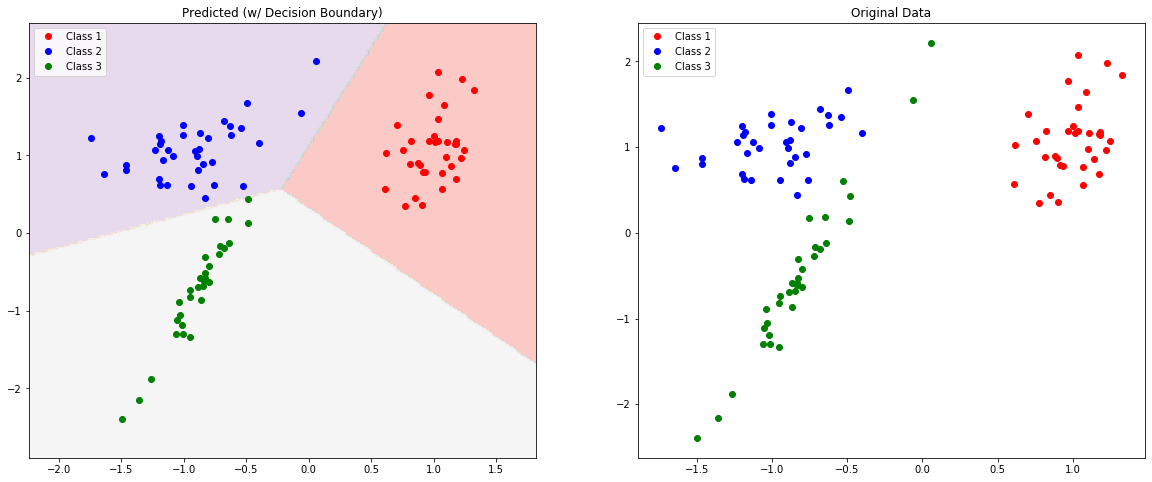

In [26]:
h = 0.02

x_min, x_max = X[:, 0].min().item() - 0.5, X[:, 0].max().item() + 0.5
y_min, y_max = X[:, 1].min().item() - 0.5, X[:, 1].max().item() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_agg = np.c_[xx.ravel(), yy.ravel()]
grid_agg = torch.from_numpy(grid_agg.astype(np.float32))

Z = model(grid_agg).detach()
Z = torch.argmax(Z, 1, keepdim=True)
Z = np.reshape(Z.numpy(), xx.shape)

cm = plt.cm.Pastel1

predicted = model(X).detach()
predicted = torch.argmax(predicted, 1, keepdim=True)
predicted = predicted.view(n_samples)

corr_fst_class_idx = y_numpy==0
corr_snd_class_idx = y_numpy==1
corr_trd_class_idx = y_numpy==2

fst_class_idx = predicted==0
snd_class_idx = predicted==1
trd_class_idx = predicted==2

fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(X_numpy[fst_class_idx, 0], X_numpy[fst_class_idx, 1], 'ro', label='Class 1')
axs[0].plot(X_numpy[snd_class_idx, 0], X_numpy[snd_class_idx, 1], 'bo', label='Class 2')
axs[0].plot(X_numpy[trd_class_idx, 0], X_numpy[trd_class_idx, 1], 'go', label='Class 3')
axs[0].contourf(xx, yy, Z, cmap=cm, alpha=0.7)
axs[0].legend(loc="upper left")
axs[0].set_title("Predicted (w/ Decision Boundary)")

axs[1].plot(X_numpy[corr_fst_class_idx, 0], X_numpy[corr_fst_class_idx, 1], 'ro', label='Class 1')
axs[1].plot(X_numpy[corr_snd_class_idx, 0], X_numpy[corr_snd_class_idx, 1], 'bo', label='Class 2')
axs[1].plot(X_numpy[corr_trd_class_idx, 0], X_numpy[corr_trd_class_idx, 1], 'go', label='Class 3')
axs[1].legend(loc="upper left")
axs[1].set_title("Original Data")

plt.show()

---

## 1.8: Dataset and Dataloader

Earlier we've managed with hand-crafted and/or toy datasets in our examples. Though, nowadays it's pretty common to deal with large datasets (in the order of millions of examples, hundreds or thousands of features and classes). In this scenario, even with state-of-the-art hardware it's recommended to save memory, paralellize computation, and make efficient use of resources. Given that, it'd be nice to come up with an implementation to ease the process of loading larger datasets. That's exactly what Pytorch's Dataset and DataLoader classes are made for.

First, let's create a subclass of Dataset for the Wine Quality dataset (which is in './data/winequality-red.csv' directory, in case you want to take a look). To do so, we need three methods: (i) initialization, (ii) a getter to fetch samples by its index, and (iii) a method to return the number of samples (dataset length):

In [27]:
class WineDataset(Dataset):

    def __init__(self, file_path):
        dataset = np.loadtxt(file_path, delimiter=",", dtype=np.float32, skiprows=1)
        self.X = torch.from_numpy(dataset[:, 1:])
        self.y = torch.from_numpy(dataset[:, 0]).view(self.X.shape[0], 1) # We want to have a label column vector
        self.n_samples = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [28]:
path = './data/winequality-red.csv'
wine_dataset = WineDataset(path)

Afterward, we can use Pytorch's DataLoader class in order to efficiently load our dataset object aiming to optimize our model's training. In this case, we'll exploit mini-batch technique.

[Quick reminder] Here is an explanation of some of the concepts used below:

* **Epoch**: Number of times training on the entire dataset
* **Iteration or Batch**: Number of batchs/forward and backward passes (optimization is done in each batch instead of the entire data)
* **Batch Size**: Number of samples in each batch

For instace, given a dataset of 1600 samples, if the batch size is 4, then the number of batchs is 400 ($\dfrac{1600}{4}$ = 400). 

The image below illustrates a dataset divided in 4 batchs. On this example, each epoch we are training (forward, backward passing, and updating parameters) on each batch, running through all the dataset in this way, but using just an amount of computing power and memory, since it's only allocated a batch per step of training.

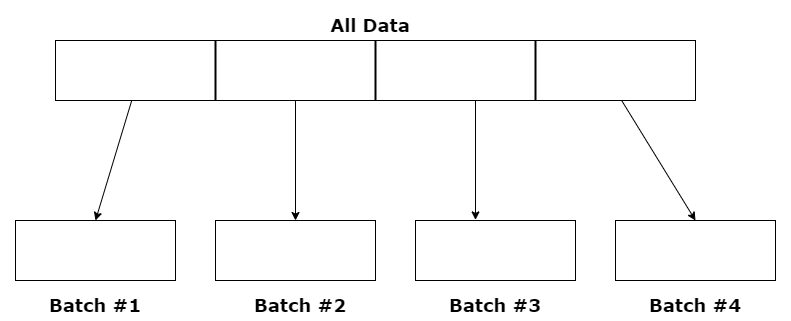

In [29]:
Image(filename="assets/images/mini-batch.png")

In [30]:
# It's choosen a batch size (i.e., numbers of samples per batch) of 4, and separate this process in 2 (number of workers = 2)
wine_dataloader = DataLoader(dataset=wine_dataset, batch_size=4, shuffle=True, num_workers=2)

In [31]:
n_epochs = 2
n_samples = len(wine_dataset)
n_iters = len(wine_dataloader)

for epoch in range(n_epochs):
    for i, (X, y) in enumerate(wine_dataloader):
        if (i+1) % 50 == 0:
            print(
                r'Epoch {epoch}/{n_epochs} | Batch {i:3}/{n_iters:} | Batch shape {X_shape}'.format(
                    epoch=epoch+1, i=i+1,                                                                      
                    n_epochs=n_epochs, n_iters=n_iters,                                                                                
                    X_shape=X.shape)
            )

Epoch 1/2 | Batch  50/400 | Batch shape torch.Size([4, 11])
Epoch 1/2 | Batch 100/400 | Batch shape torch.Size([4, 11])
Epoch 1/2 | Batch 150/400 | Batch shape torch.Size([4, 11])
Epoch 1/2 | Batch 200/400 | Batch shape torch.Size([4, 11])
Epoch 1/2 | Batch 250/400 | Batch shape torch.Size([4, 11])
Epoch 1/2 | Batch 300/400 | Batch shape torch.Size([4, 11])
Epoch 1/2 | Batch 350/400 | Batch shape torch.Size([4, 11])
Epoch 1/2 | Batch 400/400 | Batch shape torch.Size([3, 11])
Epoch 2/2 | Batch  50/400 | Batch shape torch.Size([4, 11])
Epoch 2/2 | Batch 100/400 | Batch shape torch.Size([4, 11])
Epoch 2/2 | Batch 150/400 | Batch shape torch.Size([4, 11])
Epoch 2/2 | Batch 200/400 | Batch shape torch.Size([4, 11])
Epoch 2/2 | Batch 250/400 | Batch shape torch.Size([4, 11])
Epoch 2/2 | Batch 300/400 | Batch shape torch.Size([4, 11])
Epoch 2/2 | Batch 350/400 | Batch shape torch.Size([4, 11])
Epoch 2/2 | Batch 400/400 | Batch shape torch.Size([3, 11])


---

## 1.9: Dataset Transforms

Transforms are built-in transformations applied to datasets, wheter its datatype is a tensor, a ndarray or a PIL image.

A few examples of transformations are:

    Images
    -------
    Pad, CenterCrop, GrayScale, RandomAffine, Resize, Scale.

    Tensors
    -------
    LinearTransformation, Normalize, RandomErasing

    Conversions
    -----------
    ToPILImage: tensor -> ndarray
    ToTensor:   ndarray -> tensor

    Generic
    -------
    Lambda function

    Custom
    ------
    Write your own class

    Compose
    -------
    Design a list of transformations:
        composed = torchvision.transforms.Compose(
            [Rescale(256),
            RandomCrop(128)]
        )

For more details, a complete list of all built-in transform functions is available at: https://pytorch.org/vision/stable/transforms.html

Let's use our own custom class dataset implemented before in order to make two transformations:

1. Transform from ndarray to tensor
2. Exponentiate our data

In [32]:
# Custom WineDataset class
class WineDataset(Dataset):

    def __init__(self, file_path, transform):
        dataset = np.loadtxt(file_path, delimiter=",", dtype=np.float32, skiprows=1)
        self.X = dataset[:, 1:]
        self.y = dataset[:, [0]]
        self.n_samples = self.X.shape[0]
        self.transform = transform

    def __getitem__(self, index):
        sample = self.X[index], self.y[index]

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return self.n_samples

In [33]:
# Transform classes

class ToTensor:
    ''' 
    Transform ndarray data into tensor
    '''

    def __call__(self, sample):
        inputs, labels = sample
        sample = torch.from_numpy(inputs), torch.from_numpy(labels) 

        return sample

class PowTransform:
    ''' 
     Raise inputs to a power 'n'
    '''

    def __init__(self, n):
        self.power = n

    def __call__(self, sample):
        inputs, labels = sample
        sample = inputs.pow(self.power), labels

        return sample

In [34]:
path = './data/winequality-red.csv'
composed = torchvision.transforms.Compose([ToTensor(), PowTransform(2)])

In [35]:
# Without transformation
wine_dataset = WineDataset(file_path=path, transform=None)

first_data = wine_dataset[0]
features, labels = first_data

print(type(features), type(labels))
print(features)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4   ]


In [36]:
# With transformation
wine_dataset = WineDataset(file_path=path, transform=composed)

first_data = wine_dataset[0]
features, labels = first_data

print(type(features), type(labels))
print(features)

<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([5.4760e+01, 4.9000e-01, 0.0000e+00, 3.6100e+00, 5.7760e-03, 1.2100e+02,
        1.1560e+03, 9.9560e-01, 1.2320e+01, 3.1360e-01, 8.8360e+01])


---

## 1.10: Softmax & Cross-Entropy

Softmax and Cross-Entropy are two frequently used functions in the field and, in particular, in neural network models. Let's dive into the math and intuition behind these functions:

### 1. Softmax

Softmax formula is represented below:

$$S(Y_i) = \dfrac{e^{Y_i}}{\sum_{j} e^{Y_j}}$$

What this function does is normalize all $Y_i$ values to keep them between $[0,1]$. In other words, it transforms real values to probability values, making sure that it respects Kolmogorov axioms (Probability Theory axioms). In our case, we use it in order to pick up the class with the greatest probability in our model's prediction. As an example, take a look in the image below. In a 3-classes classification problem, for that particular fiction observation, our model would choose the first one (with almost $80\%$ probability that this is observation's class).

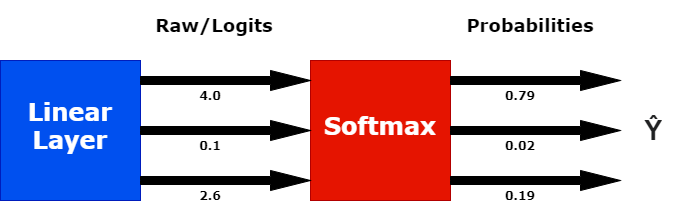

In [37]:
Image(filename="assets/images/softmax_ex.png")

As we've done before, let's implement Softmax function in two ways: (i) from scratch; (ii) with Pytorch.

In [38]:
# Softmax function from scratch
def softmax(logits):
    return np.exp(logits)/np.sum(np.exp(logits))

logits = np.array([4, 0.1, 2.6])
y_hat = softmax(logits)

print('Probabilities:', np.round(y_hat, 2), '(as expected!)')

Probabilities: [0.79 0.02 0.19] (as expected!)


In [39]:
# Softmax function with Pytorch
logits = torch.tensor([4, 0.1, 2.6])
y_hat = torch.softmax(logits, dim=0)

print('Probabilities:', np.round(y_hat.numpy(), 2), '(as expected!)')

Probabilities: [0.79 0.02 0.19] (as expected!)


### 2. Cross-Entropy

As stated above, Cross-Entropy is another famous function used in the field. In this case, it's used as the loss function which we want to optimize in classification problems. Its formula is represented below:

$$H(\hat{Y}, Y) = -\dfrac{1}{N}\sum_{i}^{N}Y_{i}log(\hat{Y_{i}})$$

Cross-Entropy is a measure of the difference between two probability distributions of two random variables (or functions). Intuitively, if the probability distribution of our model's prediction is similar to that of the real label, them cross-entropy will have a small value. Otherwise, i.e. the two probability distributions are different, cross-entropy is high. Examples are shown below:

1)
$
{Y = [1, 0, 0] \\ \hat{Y_{1}} = [0.79, 0.02, 0.19]} H_{1}(\hat{Y_{1}}, Y) = 0.24
$

2)
$
{Y = [1, 0, 0] \\ \hat{Y_{2}} = [0.19, 0.02, 0.79]} H_{2}(\hat{Y_{2}}, Y) = 1.66
$

**Obs. (1):** To compute cross-entropy, labels must be one-hot encoded (just like it is in the example) and predictions must be probabilities (i.e., it must be transformed by softmax).

**Obs. (2):** Pytorch's Cross-Entropy interface (_torch.nn.CrossEntropyLoss()_) ease things a little bit. Our label vector doesn't need to be one-hot encoded, so label values are just the class value. Also, it internally applies softmax to the prediction vector. Thus we need to pass the logits vector. This observation is **paramount** because when we start coding our neural networks in the future we'll need to remind that Pytorch's Cross-Entropy Loss already pass results in a Softmax layer, therefore we don't need to add this layer again. Nonetheless, in the case the intended task is a binary classification, Pytorch's Binary Cross-Entropy Loss (_torch.nn.BCELoss()_) will require a Sigmoid function layer in the end of the neural network. Please keep that in mind!

In [40]:
# Cross-Entropy function from scratch
def cross_entropy(y, y_hat):
    N = 1
    return -np.sum(y*np.log(y_hat))/N

y = np.array([1, 0, 0])
y_hat_1 = np.array([0.79, 0.02, 0.19])
y_hat_2 = np.array([0.19, 0.02, 0.79])

CE_1 = cross_entropy(y, y_hat_1)
CE_2 = cross_entropy(y, y_hat_2)

display(Math(r'H_1 = {ce_1:.2f} \ | \ H_2 = {ce_2:.2f} \ (as \ expected!)'.format(ce_1=CE_1, ce_2=CE_2)))

<IPython.core.display.Math object>

In [41]:
# Cross-Entropy function with Pytorch
y = torch.tensor([0]) # Only one label in a 3-classes classification problem.
y_hat_1 = torch.tensor([[4, 0.1, 2.6]])
y_hat_2 = torch.tensor([[2.6, 0.1, 4]])

loss = nn.CrossEntropyLoss()
CE_1 = loss(y_hat_1, y)
CE_2 = loss(y_hat_2, y)

display(Math(r'H_1 = {ce_1:.2f} \ | \ H_2 = {ce_2:.2f} \ (as \ expected!)'.format(ce_1=CE_1, ce_2=CE_2)))

<IPython.core.display.Math object>

---

## 1.11: Activation Functions

Activation functions are important features of neural networks because they allow them to **model non-linear relations** present in the data. An analogy often used is that of the all-or-none principle that control our nerve cells' response given a stimulus and the intuition behind activation functions on artificial neural networks (yet, this comparison is quite questionable).

Next, we're going to see some of the activation functions implemented in Pytorch and their idiosyncrasies:

### 1. Step Function

This is the most simple activation function. It's described as follows:

$$f(x) = \left\{
\begin{array}{ll}
    1,  & x \geq a \\
    0,  & x < a\\
\end{array}
\right.
$$

That means whenever the neuron value is greater than a value ($a$, in this case), then it activates.

**Obs.:** This function is hardly ever used.

Below, it's a graphic representation of that function:

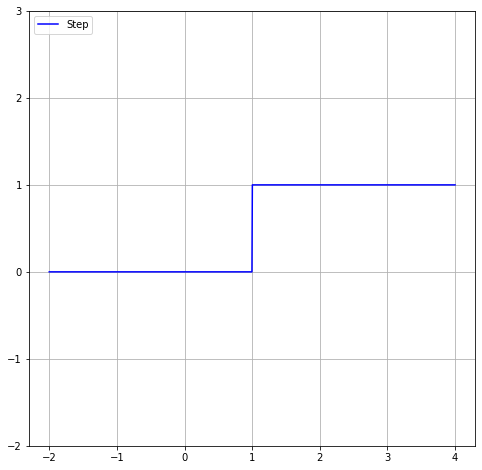

In [42]:
X = np.linspace(-2, 4, 1000, dtype=np.float64)
X = torch.from_numpy(X)
inputs = X
values = torch.tensor([1], dtype=torch.float64)

a = 1
step = torch.heaviside(inputs-a, values) # Pytorch's step function
step = step.numpy()

fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.plot(inputs, step, 'b-', label="Step")
axs.legend(loc="upper left")
axs.set_ylim([-2, 3])
plt.grid()
plt.show()

### 2. Logistic

Logistic function, also kwon as sigmoid, is an activation function that outputs a probability value and is usually used in the last layer of a binary classification problem. It's formula is represented below:

$$f(x) = \dfrac{1}{1+e^{-x}}$$

Graphically, logistic function is as follows:

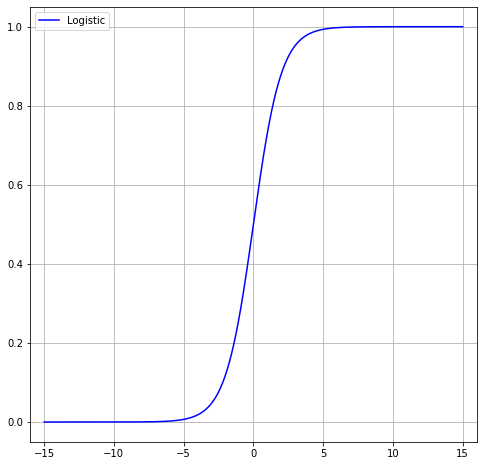

In [43]:
X = np.linspace(-15, 15, 1000, dtype=np.float64)
X = torch.from_numpy(X)

logistic = nn.Sigmoid() # Pytorch's logistic function (also known as just sigmoid)
logits = logistic(X)
logits = logits.numpy()

fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.plot(X, logits, 'b-', label="Logistic")
axs.legend(loc="upper left")
axs.set_xlim([-16, 16])
plt.grid()
plt.show()

### 3. Tanh

Tanh is another function from the sigmoid family. Nonetheless, instead of having its output value between $[0,1]$, it's scaled and shifted in order to be between $[-1,1]$. The formula and plot is represented below:

$$f(x) = \dfrac{2}{1 + e^{-2x}} - 1$$

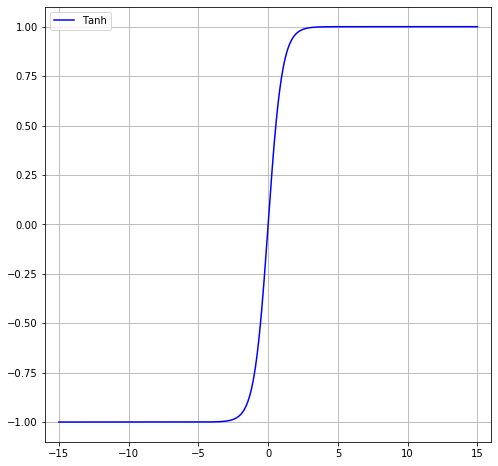

In [44]:
X = np.linspace(-15, 15, 1000, dtype=np.float64)
X = torch.from_numpy(X)

sigmoid_tanh = nn.Tanh() # Pytorch's tanh function
tanh = sigmoid_tanh(X)
tanh = tanh.numpy()

fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.plot(X, tanh, 'b-', label="Tanh")
axs.legend(loc="upper left")
axs.set_xlim([-16, 16])
plt.grid()
plt.show()

### 4. ReLU

Probably the most popular activation function (and the best candidate if you're in doubt which one to use), ReLU outputs $0$ in the case input is **negative**, and is the idendity ($f(x) = x$) otherwise. ReLU formula is below:

$$f(x) = max(0, x)$$

Next, it's presented ReLU graphically:

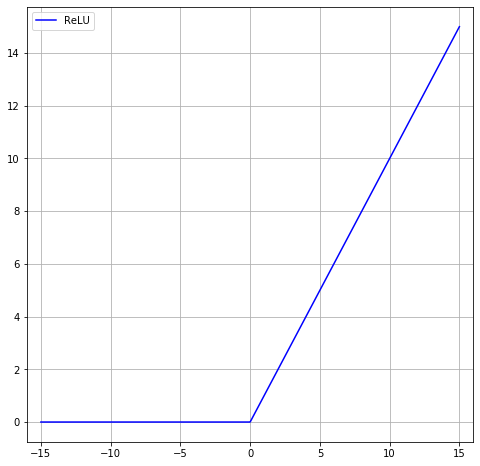

In [45]:
X = np.linspace(-15, 15, 1000, dtype=np.float64)
X = torch.from_numpy(X)

relu_func = nn.ReLU() # Pytorch's ReLU function
relu = relu_func(X)
relu = relu.numpy()

fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.plot(X, relu, 'b-', label="ReLU")
axs.legend(loc="upper left")
axs.set_xlim([-16, 16])
plt.grid()
plt.show()

### 5. Leaky ReLU

Leaky ReLU is a variation of ReLU function, but it's not $0$ for negative input values. What this function seeks to improve is what is called vanishing gradient problem, which is the result of a null gradient value, due to null activation. To addres this problem, it's used a small term ($\alpha$) (in the order of $0.01$) for negative input values, and so the gradient does not vanish. Leaky ReLU formula and its plot is as follows:

$$f(x) = \left\{
\begin{array}{ll}
    x,  & x \geq 0 \\
    {\alpha}x,  & x < 0\\
\end{array}
\right.
$$

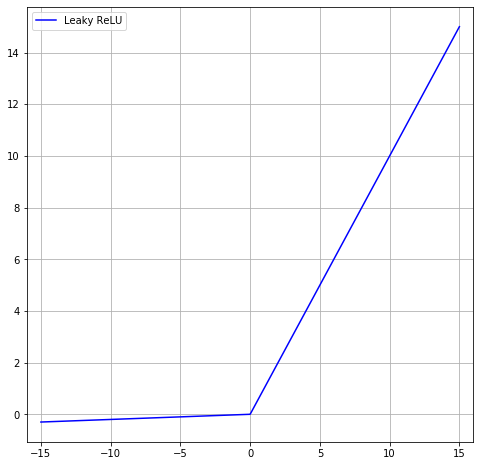

In [46]:
X = np.linspace(-15, 15, 1000, dtype=np.float64)
X = torch.from_numpy(X)

leaky_relu_func = nn.LeakyReLU(negative_slope=0.02) # Pytorch's LeakyReLU function
leaky_relu = leaky_relu_func(X)
leaky_relu = leaky_relu.numpy()

fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.plot(X, leaky_relu, 'b-', label="Leaky ReLU")
axs.legend(loc="upper left")
axs.set_xlim([-16, 16])
plt.grid()
plt.show()

### 6. Softmax

Softmax formula is represented below:

$$S(Y_i) = \dfrac{e^{Y_i}}{\sum_{j} e^{Y_j}}$$

What this function does is normalize all $Y_i$ values to keep them between $[0,1]$. In other words, it transforms real values to probability values, making sure that it respects Kolmogorov axioms (Probability Theory axioms). In our case, we use it in order to pick up the class with the greatest probability in our model's prediction. As an example, take a look in the image below. In a 3-classes classification problem, for that particular fiction observation, our model would choose the first one (with almost $80\%$ probability that this is observation's class).

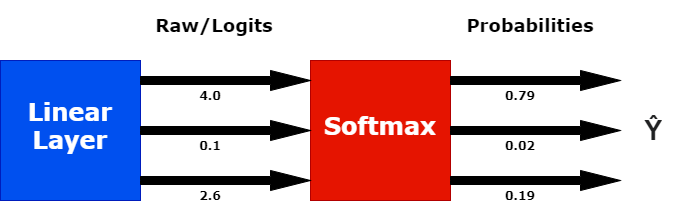

In [47]:
Image(filename="assets/images/softmax_ex.png")

In [48]:
logits = torch.tensor([4, 0.1, 2.6])
y_hat = torch.softmax(logits, dim=0) # Pytorch's softmax function

print('Probabilities:', np.round(y_hat.numpy(), 2), '(as expected!)')

Probabilities: [0.79 0.02 0.19] (as expected!)


---

## 1.12: Feedforward Neural Networks

In [49]:
class NeuralNet(nn.Module):

    def __init__(self, in_units, hid_units, hid_layers, out_units):
        super().__init__()
        self.num_in_units = in_units
        self.num_hid_layers = hid_layers

        self.hidden_layers = [nn.Linear(in_features=in_units, out_features=hid_units)]
        self.act_functions = [nn.ReLU()]

        for l in range(1, hid_layers):
            self.hidden_layers.append(nn.Linear(in_features=hid_units, out_features=hid_units))
            self.act_functions.append(nn.ReLU())

        self.output_layer = nn.Linear(in_features=hid_units, out_features=out_units)

    def forward(self, x):
        x = x.view(-1, self.num_in_units)
        out = self.hidden_layers[0](x)
        out = self.act_functions[0](out)

        for l in range(1, self.num_hid_layers):
            out = self.hidden_layers[l](out)
            out = self.act_functions[l](out)

        prediction = self.output_layer(out)

        return prediction

In [ ]:
# Define hyperparameters
lr=0.001
num_epochs=10
batch_size = 64
torch.manual_seed(42)

# Loading and transforming data
composed = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.1307], [0.3081])])
# composed = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=composed)
train_dataloader = DataLoader(dataset=mnist_train_dataset, batch_size=batch_size, shuffle=True)

mnist_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=composed)
test_dataloader = DataLoader(dataset=mnist_test_dataset, batch_size=batch_size, shuffle=True)

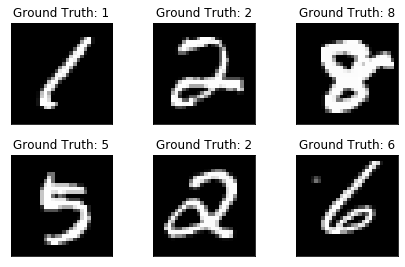

In [51]:
examples = enumerate(train_dataloader)
batch_idx, (example_features, example_targets) = next(examples)

fig = plt.figure()

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_features[i][0], cmap='gray')
    plt.title(r'Ground Truth: {label}'.format(label=example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig.show()

In [52]:
# Design model
n_test_samples = len(mnist_test_dataset)
n_samples = len(mnist_train_dataset)
n_features = (
    mnist_train_dataset.train_data.shape[1]*mnist_train_dataset.train_data.shape[2]
)
n_classes = mnist_train_dataset.targets.unique().shape[0]
model = NeuralNet(n_features, 120, 2, n_classes)

# Construct Loss and Optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
# test_losses = []

for epoch in range(num_epochs):
    train_acc = 0
    test_acc = 0
    for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
        # Forward pass
        y_hat = model(X_train)

        pred = torch.max(y_hat.data, 1)[1]
        batch_corr = (pred==y_train).sum()
        train_acc += batch_corr

        # Loss computation
        J = loss(y_hat, y_train)

        # Backward pass
        J.backward()

        # Update parameters
        optimizer.step()

        # Zero grad
        optimizer.zero_grad()

        # Print train loss
        if batch_idx % 10 == 0:
            print('Train Epoch {} [{:>5}/{} ({:>2.0f}%)] | Loss: {}'.format(
                epoch+1, batch_idx * batch_size, n_samples, 
                100*batch_idx / len(train_dataloader), J))
            train_losses.append(J)

    with torch.no_grad():
        for batch_idx, (X_test, y_test) in enumerate(test_dataloader):
            # Forward pass
            y_val = model(X_test)

            pred = torch.max(y_val.data, 1)[1]
            batch_corr = (pred==y_test).sum()
            test_acc += batch_corr

    print('\nTrain Acc.: [{:>5}/{} ({:>2.0f}%)]'.format(train_acc, n_samples, 100 * train_acc / n_samples))
    print('Test Acc.: [{:>5}/{} ({:>2.0f}%)]\n'.format(test_acc, n_test_samples, 100 * test_acc / n_test_samples))

/home/caio/miniconda3/envs/GNENV/lib/python3.7/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train Epoch 1 [    0/60000 ( 0%)] | Loss: 2.311711311340332
Train Epoch 1 [  640/60000 ( 1%)] | Loss: 2.2749290466308594
Train Epoch 1 [ 1280/60000 ( 2%)] | Loss: 2.2491490840911865
Train Epoch 1 [ 1920/60000 ( 3%)] | Loss: 2.2630879878997803
Train Epoch 1 [ 2560/60000 ( 4%)] | Loss: 2.216179132461548
Train Epoch 1 [ 3200/60000 ( 5%)] | Loss: 2.2108724117279053
Train Epoch 1 [ 3840/60000 ( 6%)] | Loss: 2.181013584136963
Train Epoch 1 [ 4480/60000 ( 7%)] | Loss: 2.145498037338257
Train Epoch 1 [ 5120/60000 ( 9%)] | Loss: 2.129136562347412
Train Epoch 1 [ 5760/60000 (10%)] | Loss: 2.1076879501342773
Train Epoch 1 [ 6400/60000 (11%)] | Loss: 2.1037516593933105
Train Epoch 1 [ 7040/60000 (12%)] | Loss: 2.0438315868377686
Train Epoch 1 [ 7680/60000 (13%)] | Loss: 2.0545883178710938
Train Epoch 1 [ 8320/60000 (14%)] | Loss: 2.053534984588623
Train Epoch 1 [ 8960/60000 (15%)] | Loss: 1.9853512048721313
Train Epoch 1 [ 9600/60000 (16%)] | Loss: 2.0020673274993896
Train Epoch 1 [10240/60000 (17

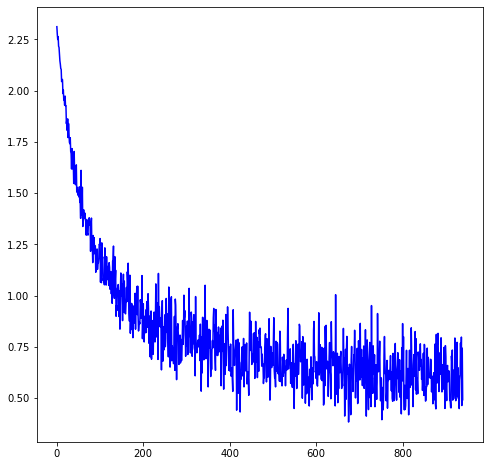

In [53]:
idx = list(range(len(train_losses)))

fig = plt.figure(figsize=(8,8))
plt.plot(idx, train_losses, 'b-')
fig.show()

---